# Recalibrating the Brunt equation using Eureka data

## Jason Kniss
### Feb 14 2024

This script is used to process the unfiltered code, intended as a test of
functionality and for the author to practice python coding

### Import Libraries

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandasgui import show
import netCDF4 as nc

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Import and organize data

### Set path to data folders

separate folders are used because each data source will be treated separately. This is to simplify identification and concatenation.

In [3]:
# Text files
towermet_path = 'data/eureka-data/tower-met'
towerrad_path = 'data/eureka-data/tower-rad'
bsrnrad_path = 'data/eureka-data/bsrn-rad'

# NetCDFs
    # For now, just one, then we'll decide how to systematically do this for many files
mwr_path = 'data/eureka-data/mwr/eurmwrlosC1.b1.20090101.000000.cdf'

In [4]:
dataset = nc.Dataset(mwr_path, mode='r')

In [5]:
print(dataset.variables.keys())  # Prints out all variable names

dict_keys(['base_time', 'time_offset', 'timeoffmid', 'averagingtime', 'wet_window', 'num_samples', 'lat', 'lon', 'alt', 'pitch', 'roll', 'heading', 'presure', 'rh', 'temperature', 'liquid', 'vapor', 'vt_sky', 'vt_ref', 't_ref', 'tb', 'liquid_coef', 'vapor_coef', 'tmr'])


In [6]:
# Assuming 'dataset' is your netCDF dataset
var = dataset.variables['base_time']

# Print all attributes of the 'vapor' variable
for attr_name in var.ncattrs():
    print(attr_name, '=', getattr(var, attr_name))
var.shape
dataset.variables['averagingtime'].dimensions

long_name = Base time in Epoch
units = seconds since 1970-1-1 00:00:00
string = 01-Jan-2009, 00:00:59 GMT


('time',)

In [7]:
time = dataset.variables['timeoffmid'][:]
averagingtime = dataset.variables['averagingtime'][:]
temperature = dataset.variables['temperature'][:]
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
presure = dataset.variables['presure'][:]
rh = dataset.variables['rh'][:]
vapor = dataset.variables['vapor'][:]
liquid = dataset.variables['liquid'][:]
tb = dataset.variables['tb'][:]

In [8]:
df1 = pd.DataFrame({
    'presure': np.where(presure.mask, np.nan, presure.data)
}, index=time)
df2 = pd.DataFrame({
    'temperature': np.where(temperature.mask, np.nan, temperature.data)
}, index=time)
df3 = pd.DataFrame({
    'rh': np.where(rh.mask, np.nan, rh.data)
}, index=time)
df4 = pd.DataFrame({
    'vapor': np.where(vapor.mask, np.nan, vapor.data)
}, index=time)
df5 = pd.DataFrame({
    'liquid': np.where(liquid.mask, np.nan, liquid.data)
}, index=time)

In [9]:
merged_df = pd.concat([df1, df2, df3, df4, df5], axis=1)

In [10]:
# Base date (midnight)
base_date = datetime(year=2009, month=1, day=1)

# Convert index
merged_df.index = base_date + pd.to_timedelta(merged_df.index, unit='s')

In [11]:
show(merged_df)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


### Crerate lists of dataframes

Loops will generate a list of dataframes from text files added to specified folders.

In [12]:
towermet_dfs = []  # List to store Tower Meteroological dataframes
towerrad_dfs = []  # List to store Tower Radiation dataframes
bsrnrad_dfs = [] # List to store BSRN radiation dataframes

### Tower meteorological data

In [13]:
for filename in os.listdir(towermet_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(towermet_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')

        # Fix midnight HourMin
        condition = df['HourMin'] == 2400
        df.loc[condition, 'JulianDay'] += 1
        df.loc[condition, 'HourMin'] = 0000

        df.replace([-999, -9999], np.nan, inplace=True)
        
        towermet_dfs.append(df)

### Tower radiation data

In [14]:
for filename in os.listdir(towerrad_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(towerrad_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        
        condition = df['HourMin'] == 2400
        df.loc[condition, 'JulianDay'] += 1
        df.loc[condition, 'HourMin'] = 0000

        df.replace([-999, -9999], np.nan, inplace=True)
        
        #df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        towerrad_dfs.append(df)

### BSRN radiation data
This is redundant of tower radiation data and only serves as a comparison to tower measurements

In [15]:
for filename in os.listdir(bsrnrad_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(bsrnrad_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        
        condition = df['HourMin'] == 2400
        df.loc[condition, 'JulianDay'] += 1
        df.loc[condition, 'HourMin'] = 0000

        df.replace([-999, -9999], np.nan, inplace=True)
        
        #df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        bsrnrad_dfs.append(df)

## Sort and concatenate lists of dataframes

Done separately to simplify concatenation in the next step
### Create datetime columns
### Tower meteorological dataframes

In [16]:
# Create a Datetime column 
for df in towermet_dfs:
    def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
        base_date = datetime(base_year, 1, 1)
        target_date = base_date + timedelta(days=julian_day - 1)
        return target_date.strftime('%Y-%m-%d')

    def hourmin_to_time(hourmin):
        hours = int(hourmin // 100)
        minutes = int(hourmin % 100)
        return f'{hours:02}:{minutes:02}:00'

    # Convert Julian Day to date
    df['Date'] = df['JulianDay'].apply(julian_to_date)

    # Convert HourMin to time   
    df['Time'] = df['HourMin'].apply(hourmin_to_time)

    # Combine date and time into a single datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Drop intermediate columns
    df.drop(columns=['Date', 'Time'], inplace=True)
    


### Tower radiation dataframes

In [17]:
for df in towerrad_dfs:
      def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
          base_date = datetime(base_year, 1, 1)
          target_date = base_date + timedelta(days=julian_day - 1)
          return target_date.strftime('%Y-%m-%d')

      def hourmin_to_time(hourmin):
          hours = int(hourmin // 100)
          minutes = int(hourmin % 100)
          return f'{hours:02}:{minutes:02}:00'

      # Convert Julian Day to date
      df['Date'] = df['JulianDay'].apply(julian_to_date)

      # Convert HourMin to time   
      df['Time'] = df['HourMin'].apply(hourmin_to_time)

      # Combine date and time into a single datetime column
      df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

      # Drop intermediate columns
      df.drop(columns=['Date', 'Time'], inplace=True)
      
      # Set 'Datetime' column as the index
 #     df.set_index('Datetime', inplace=True)

### BSRN radiation dataframes

In [18]:
for df in bsrnrad_dfs:
    def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
        base_date = datetime(base_year, 1, 1)
        target_date = base_date + timedelta(days=julian_day - 1)
        return target_date.strftime('%Y-%m-%d')

    def hourmin_to_time(hourmin):
        hours = int(hourmin // 100)
        minutes = int(hourmin % 100)
        return f'{hours:02}:{minutes:02}:00'

    # Convert Julian Day to date
    df['Date'] = df['JulianDay'].apply(julian_to_date)

    # Convert HourMin to time   
    df['Time'] = df['HourMin'].apply(hourmin_to_time)

    # Combine date and time into a single datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Drop intermediate columns
    df.drop(columns=['Date', 'Time'], inplace=True)

### Concatenate lists of dataframes into dataframes and reindex by datetime

In [19]:
# Concatenate vertically
towermet_df = pd.concat(towermet_dfs, ignore_index=True)
towerrad_df = pd.concat(towerrad_dfs, ignore_index=True)
bsrnrad_df = pd.concat(bsrnrad_dfs, ignore_index=True)

In [20]:
# Sort by datetime column
towermet_df.sort_values(by='Datetime', inplace=True)    
towerrad_df.sort_values(by='Datetime', inplace=True)  
bsrnrad_df.sort_values(by='Datetime', inplace=True)

In [21]:
# Set 'Datetime' column as the index
towermet_df.set_index('Datetime', inplace=True)
towerrad_df.set_index('Datetime', inplace=True)
bsrnrad_df.set_index('Datetime', inplace=True)

### Join dataframes into one dataframe with pertinant columns

In [22]:
towermet_df_select = towermet_df[['Pressure[mbar]', '10MRH[%]', '6MRH[%]', '2MRH[%]', '10MVTair[degC]', '6MVTair[degC]', '2MVTair[degC]']]

towerrad_df_select = towerrad_df[['LWTotalDownwelling[W/m^2]', 'QualityControl']].copy()
towerrad_df_select.rename(columns={'LWTotalDownwelling[W/m^2]': 'twrLWTotalDownwelling[W/m^2]'}, inplace=True)
towerrad_df_select.rename(columns={'QualityControl': 'twrQualityControl'}, inplace=True)

bsrnrad_df_select = bsrnrad_df[['LWTotalDownwelling[W/m^2]', 'QualityControl']].copy()
bsrnrad_df_select.rename(columns={'LWTotalDownwelling[W/m^2]': 'bsrnLWTotalDownwelling[W/m^2]'}, inplace=True)
bsrnrad_df_select.rename(columns={'QualityControl': 'bsrnQualityControl'}, inplace=True)

data_df = towermet_df_select.join(towerrad_df_select, how='outer').join(bsrnrad_df_select, how='outer')

## Generate filters

#### Choose to use bsrn LWD or tower LWD

Comment out the other

In [23]:
# To use bsrn
data_df.rename(columns={'bsrnLWTotalDownwelling[W/m^2]': 'LWTotalDownwelling[W/m^2]'}, inplace=True)

# To use tower
# data_df.rename(columns={'twrLWTotalDownwelling[W/m^2]': 'LWTotalDownwelling[W/m^2]'}, inplace=True)

#### Quality Control flags

In [24]:
# Come back to this when I figure out how to QC works

#### Outliers

Eliminate outliars (2 std deviations, rolling)

This must remain the first filter, as it is dependent upon the relationship between neighboring measurements in time

In [25]:
columns_to_filter = [
    'Pressure[mbar]',
    '10MRH[%]',
    '2MRH[%]',
    '10MVTair[degC]', 
    '2MVTair[degC]',
    'LWTotalDownwelling[W/m^2]'
]

In [26]:
# Parameters
window_size = 20 # Five minute window
z_score_threshold = 2 # two standard deviations

outlier_mask_df = pd.DataFrame(index=data_df.index)
z_scores_df = pd.DataFrame(index=data_df.index)

# iterate over each selected column
for column in columns_to_filter:
    # Calculate rolling mean and std deviation
    rolling_mean = data_df[column].rolling(window=window_size, center=True).mean()
    rolling_std = data_df[column].rolling(window=window_size, center=True).std()

    # Calculate z-score for the current column
    z_scores = (data_df[column] - rolling_mean) / rolling_std

    # Save Z-scores in the new DataFrame
    z_scores_df[column + '_z_score'] = z_scores
    
    # Filter outliers based on z_score threshold
    non_outlier_mask = (z_scores.abs() <= z_score_threshold) | pd.isna(z_scores)
    outlier_mask_df[column + '_is_not_outlier'] = non_outlier_mask

data_df['isnotoutlier'] = outlier_mask_df[[col + '_is_not_outlier' for col in columns_to_filter]].all(axis=1)
    
# outlier_mask = outlier_mask_df[[col + '_is_not_outlier' for col in columns_to_filter]].all(axis=1)
# data_df = data_df[outlier_mask]

In [27]:
# inverse_mask = ~outlier_mask

# show(ref_df)
# show(z_scores_df[inverse_mask])

#### RH cannot be negetive

In [28]:
data_df.loc[data_df['2MRH[%]'] < 0, '2MRH[%]'] = np.nan
data_df.loc[data_df['6MRH[%]'] < 0, '6MRH[%]'] = np.nan
data_df.loc[data_df['10MRH[%]'] < 0, '10MRH[%]'] = np.nan

#### View Dataframes and Info

In [29]:
data_df.head()

,Pressure[mbar],10MRH[%],6MRH[%],2MRH[%],10MVTair[degC],6MVTair[degC],2MVTair[degC],twrLWTotalDownwelling[W/m^2],twrQualityControl,LWTotalDownwelling[W/m^2],bsrnQualityControl,isnotoutlier
Datetime,,,,,,,,,,,,
2009-01-01 00:00:00,1009.8,64.315,62.984,61.374,-35.070,-35.191,-35.680,182.150,9.000000e+10,NaN,NaN,True
2009-01-01 00:01:00,1009.8,62.975,62.150,60.589,-34.944,-35.093,-35.755,182.109,9.000000e+10,150.10,9.091991e+15,True
2009-01-01 00:02:00,1009.8,63.003,62.699,59.687,-34.976,-35.138,-35.828,182.317,9.000000e+10,150.48,9.091991e+15,True
2009-01-01 00:03:00,1009.7,63.520,63.929,59.662,-34.968,-35.133,-35.864,182.290,9.000000e+10,150.36,9.091991e+15,True
2009-01-01 00:04:00,1009.6,65.087,65.951,60.625,-34.909,-35.060,-35.860,182.319,9.000000e+10,150.57,9.091991e+15,True


In [30]:
data_df.describe()

,Pressure[mbar],10MRH[%],6MRH[%],2MRH[%],10MVTair[degC],6MVTair[degC],2MVTair[degC],twrLWTotalDownwelling[W/m^2],twrQualityControl,LWTotalDownwelling[W/m^2],bsrnQualityControl
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1440.000000,1.440000e+03
mean,1008.418403,64.313028,64.830333,62.048199,-32.379636,-32.500304,-33.022478,188.416342,9.000000e+10,173.152896,2.603644e+16
std,0.968669,1.333596,1.333707,1.170353,1.138639,1.052284,0.990541,3.373707,0.000000e+00,24.909017,2.676780e+17
min,1006.600000,60.138000,59.160000,58.506000,-35.112000,-35.191000,-35.864000,182.089000,9.000000e+10,147.090000,9.091991e+15
25%,1007.500000,63.426750,64.007250,61.298000,-33.165000,-33.335500,-33.849250,185.582500,9.000000e+10,150.797500,9.091991e+15
50%,1008.600000,64.315000,64.877000,62.064000,-32.423000,-32.528500,-33.004500,188.045000,9.000000e+10,160.920000,9.091991e+15
75%,1009.200000,65.124000,65.694500,62.830500,-31.466250,-31.687000,-32.341000,190.634250,9.000000e+10,196.955000,9.091991e+15
max,1010.100000,68.614000,68.989000,66.058000,-29.611000,-29.729000,-30.771000,197.145000,9.000000e+10,230.830000,5.309092e+18


In [31]:
# ref_df.describe()

In [32]:
data_df.columns

Index(['Pressure[mbar]', '10MRH[%]', '6MRH[%]', '2MRH[%]', '10MVTair[degC]',
       '6MVTair[degC]', '2MVTair[degC]', 'twrLWTotalDownwelling[W/m^2]',
       'twrQualityControl', 'LWTotalDownwelling[W/m^2]', 'bsrnQualityControl',
       'isnotoutlier'],
      dtype='object')

In [33]:
data_df.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:01:00',
               '2009-01-01 00:02:00', '2009-01-01 00:03:00',
               '2009-01-01 00:04:00', '2009-01-01 00:05:00',
               '2009-01-01 00:06:00', '2009-01-01 00:07:00',
               '2009-01-01 00:08:00', '2009-01-01 00:09:00',
               ...
               '2009-01-01 23:51:00', '2009-01-01 23:52:00',
               '2009-01-01 23:53:00', '2009-01-01 23:54:00',
               '2009-01-01 23:55:00', '2009-01-01 23:56:00',
               '2009-01-01 23:57:00', '2009-01-01 23:58:00',
               '2009-01-01 23:59:00', '2009-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=1441, freq=None)

### Night Filter

This filter takes out any data when the sun is less than 15 degrees below the horizon.

#### Get back JulianDay

In [34]:
data_df['JulianDay'] = data_df.index.dayofyear

In [35]:
# Set Lat and Long for stationary sites
lat = 79.983 # North(+)
long = 85.95 # West(+)

#### 1) Determine declination

define sin/cos functions that expect degrees as the input

In [36]:
def cosd(degrees):
     return np.cos(np.deg2rad(degrees))
def sind(degrees):
    return np.sin(np.deg2rad(degrees))

In [37]:
data_df['B'] = (data_df['JulianDay'] - 1)*(360/365)
data_df['decl'] = (180/np.pi)*(0.006918 - 0.399912*cosd(data_df['B']) + 0.070257*sind(data_df['B']) - 0.006785*cosd(2*data_df['B']) + 0.000907*sind(2*data_df['B']) - 0.002697*cosd(3*data_df['B']) + 0.00148*sind(3*data_df['B']))
# data_df['decl'] = 23.45*sind(360*(284 + data_df['JulianDay'])/365) # Less accurate but typically adequate for most engineering purposes

#### 2) Determine hour angle

2a) determine local time in terms of minutes from solar noon (+ afternoon, - morning)

**Eureka data is logged as GMT/UTC time**

In [38]:
data_df['E'] = 229.2*(0.000075 + 0.001868*cosd(data_df['B']) - 0.032077*sind(data_df['B']) - 0.014615*cosd(2*data_df['B']) - 0.04089*sind(2*data_df['B']))

data_df['t_corr'] = round(4*(0-long) + data_df['E'])

In [39]:
data_df['t_corr']

Datetime
2009-01-01 00:00:00   -347.0
2009-01-01 00:01:00   -347.0
2009-01-01 00:02:00   -347.0
2009-01-01 00:03:00   -347.0
2009-01-01 00:04:00   -347.0
                       ...  
2009-01-01 23:56:00   -347.0
2009-01-01 23:57:00   -347.0
2009-01-01 23:58:00   -347.0
2009-01-01 23:59:00   -347.0
2009-01-02 00:00:00   -347.0
Name: t_corr, Length: 1441, dtype: float64

Calculate local (solar) time

In [40]:
data_df['LocalTime'] = data_df.index.to_series().apply(lambda dt: dt + pd.Timedelta(minutes=int(data_df.loc[dt, 't_corr'])))

Calculate minutes from solar noon

In [41]:
data_df['date'] = data_df['LocalTime'].dt.date

data_df['noon'] = pd.to_datetime(data_df['date'].astype(str) + ' 12:00:00')

data_df['minutes_from_noon'] = (data_df['LocalTime'] - data_df['noon']).dt.total_seconds() / 60

data_df = data_df.drop(['date', 'noon'], axis=1)

Calculate hour angle (w)

In [42]:
data_df['w'] = data_df['minutes_from_noon'] * (360/1440)

#### 3) Calculate zenith angle

Zenith angle is the angle between the verticle to the sun. It is the compliment of the altitude angle, which represents the angle between the sun and the horizon.

In [43]:
data_df['theta_z'] =  np.degrees(np.arccos(cosd(lat) * cosd(data_df['decl']) * cosd(data_df['w']) + sind(lat) * sind(data_df['decl'])))

In [44]:
print(min(data_df['theta_z']))
print(max(data_df['theta_z']))

103.04317615530732
123.07717615530733


#### 4) Determine whether it is night based on the zenith angle

We will define 'night' as when the sun is 15 degrees or more below the horizon, or when zenith angle exceeds 105

In [45]:
data_df['isnight'] = data_df['theta_z'] > 95

In [46]:
data_df

,Pressure[mbar],10MRH[%],6MRH[%],2MRH[%],10MVTair[degC],6MVTair[degC],2MVTair[degC],twrLWTotalDownwelling[W/m^2],twrQualityControl,LWTotalDownwelling[W/m^2],...,JulianDay,B,decl,E,t_corr,LocalTime,minutes_from_noon,w,theta_z,isnight
Datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1009.8,64.315,62.984,61.374,-35.070,-35.191,-35.680,182.150,9.000000e+10,NaN,...,1,0.000000,-23.060176,-2.904422,-347.0,2008-12-31 18:13:00,373.0,93.25,113.253496,True
2009-01-01 00:01:00,1009.8,62.975,62.150,60.589,-34.944,-35.093,-35.755,182.109,9.000000e+10,150.10,...,1,0.000000,-23.060176,-2.904422,-347.0,2008-12-31 18:14:00,374.0,93.50,113.296976,True
2009-01-01 00:02:00,1009.8,63.003,62.699,59.687,-34.976,-35.138,-35.828,182.317,9.000000e+10,150.48,...,1,0.000000,-23.060176,-2.904422,-347.0,2008-12-31 18:15:00,375.0,93.75,113.340458,True
2009-01-01 00:03:00,1009.7,63.520,63.929,59.662,-34.968,-35.133,-35.864,182.290,9.000000e+10,150.36,...,1,0.000000,-23.060176,-2.904422,-347.0,2008-12-31 18:16:00,376.0,94.00,113.383942,True
2009-01-01 00:04:00,1009.6,65.087,65.951,60.625,-34.909,-35.060,-35.860,182.319,9.000000e+10,150.57,...,1,0.000000,-23.060176,-2.904422,-347.0,2008-12-31 18:17:00,377.0,94.25,113.427427,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-01 23:56:00,1007.0,64.239,64.277,62.600,-31.433,-31.746,-31.801,194.803,9.000000e+10,204.33,...,1,0.000000,-23.060176,-2.904422,-347.0,2009-01-01 18:09:00,369.0,92.25,113.079621,True
2009-01-01 23:57:00,1007.0,64.493,64.850,62.608,-31.401,-31.747,-31.815,194.898,9.000000e+10,203.49,...,1,0.000000,-23.060176,-2.904422,-347.0,2009-01-01 18:10:00,370.0,92.50,113.123082,True
2009-01-01 23:58:00,1007.1,65.445,65.413,63.221,-31.391,-31.751,-31.805,194.958,9.000000e+10,202.73,...,1,0.000000,-23.060176,-2.904422,-347.0,2009-01-01 18:11:00,371.0,92.75,113.166549,True


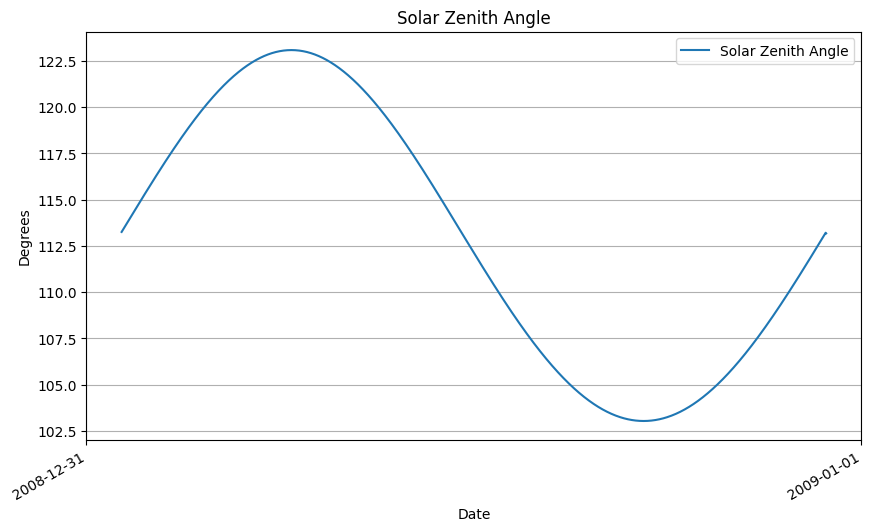

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(data_df['LocalTime'], data_df['theta_z'], label='Solar Zenith Angle')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show a tick every 5 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date

plt.xlabel('Date')
plt.ylabel('Degrees')
plt.title('Solar Zenith Angle')

plt.grid(True)

plt.gcf().autofmt_xdate()

plt.legend()

The discontinuities at visible are the result of declination changing once per day, by our equation.

#### Clear-sky filter 1

Comparison to expected emissivity

In [48]:
# THIS IS A TEST
np.random.seed(0) #for reproducibility
data_df['isclear1'] = np.random.choice([True, False], size=len(data_df))

#### Create tool for selecting filters

In [49]:
# This lists all filters available, it does not apply these filters
filters = {
    'isnotoutlier': data_df['isnotoutlier'] == True,
    'isnight': data_df['isnight'] == True,
    'isclear1': data_df['isclear1'] == True,
}

In [50]:
def select_filters(filters, filter_keys):
    # Start with a Series of True values (assuming you want to include all rows by default)
    select = pd.Series([True] * len(data_df), index=data_df.index)
    
    # Iterate through the keys of the conditions you want to apply and combine them
    for key in filter_keys:
        select &= filters[key]  # Using &= to apply logical AND with the current condition
        
    return select

## Select filters to apply

List of Filters

'isnotoutlier', 'isnight', 'isclear1'

In [51]:
# This selects which filters to apply
filter_keys = [
    'isnotoutlier', 
    'isnight', 
    # 'isclear1'
]  # Add or remove condition keys as needed (copy/paste from list above)

# Get the combined condition
selected_filters = select_filters(filters, filter_keys)
filtered_df = data_df[selected_filters].copy()

In [52]:
len(data_df), len(data_df) - len(filtered_df)

(1441, 84)

## 1) Calculate effective emissivity

### Calculate effective emissivity from measured DLR and Temperature

$\varepsilon = \frac{\rm DLR}{\sigma T_a}$

In [53]:
SIGMA = 5.67e-8

In [54]:
# Convert temperature from Celsius to Kelvin

filtered_df['T2_K'] = filtered_df['2MVTair[degC]'] + 273.15 
filtered_df['T6_K'] = filtered_df['6MVTair[degC]'] + 273.15 
filtered_df['T10_K'] = filtered_df['10MVTair[degC]'] + 273.15 

# Calculate effective emissivity
filtered_df['eps2'] = filtered_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * filtered_df['T2_K']**4)
filtered_df['eps6'] = filtered_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * filtered_df['T6_K']**4)
filtered_df['eps10'] = filtered_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * filtered_df['T10_K']**4)

## 2) Calculate expected DLR 
The Brunt form of the equation for clear sky emissivity is:

$\varepsilon_c = c_1 + c_2\sqrt{P_w}$


*This step will come after fitting a power curve to the measured DLR data*

Calculate Partial Pressure of water vapor (hPa)

In [55]:
filtered_df['Pw2'] = 610.94*(filtered_df['2MRH[%]']/100)*np.exp((17.625*(filtered_df['T2_K'] - 273.15))/(filtered_df['T2_K'] - 30.11))/100
filtered_df['Pw6'] = 610.94*(filtered_df['6MRH[%]']/100)*np.exp((17.625*(filtered_df['T6_K'] - 273.15))/(filtered_df['T6_K'] - 30.11))/100
filtered_df['Pw10'] = 610.94*(filtered_df['10MRH[%]']/100)*np.exp((17.625*(filtered_df['T10_K'] - 273.15))/(filtered_df['T10_K'] - 30.11))/100

In [56]:
# mwr measurements
merged_df['Pw2'] = 610.94*(merged_df['rh']/100)*np.exp((17.625*(merged_df['temperature'] - 273.15))/(merged_df['temperature'] - 30.11))/100

Calculate clear sky emissivity
*Parameters per the original Brunt equation. **Don't Run both emissivity cells***


In [57]:
filtered_df['e2'] = (0.52 + 0.065*np.sqrt(filtered_df['Pw2']))
filtered_df['e6'] = (0.52 + 0.065*np.sqrt(filtered_df['Pw6']))
filtered_df['e10'] = (0.52 + 0.065*np.sqrt(filtered_df['Pw10']))

In [58]:
# mwr measurements
merged_df['e2'] = (0.52 + 0.065*np.sqrt(merged_df['Pw2']))

Calculate clear sky emissivity
*Calibrated parameters per Li et al. 2017. **Don't Run both emissivity cells***

In [59]:
# filtered_df['e2'] = (0.618 + 0.054*np.sqrt(filtered_df['Pw2']))
# filtered_df['e6'] = (0.618 + 0.054*np.sqrt(filtered_df['Pw6']))
# filtered_df['e10'] = (0.618 + 0.054*np.sqrt(filtered_df['Pw10']))

In [60]:
# mwr measurements
# merged_df['e2'] = (0.618 + 0.054*np.sqrt(merged_df['Pw2']))

Calculate expected DLR

In [61]:
filtered_df['DLR2'] = filtered_df['e2']*SIGMA*(filtered_df['T2_K']**4)
filtered_df['DLR6'] = filtered_df['e6']*SIGMA*(filtered_df['T6_K']**4)
filtered_df['DLR10'] = filtered_df['e10']*SIGMA*(filtered_df['T10_K']**4)

In [72]:
# mwr measurements
merged_df['DLR2'] = merged_df['e2']*SIGMA*(merged_df['temperature']**4)

# merged_df['DLR'] = 123.86 + 0.444 * (SIGMA * merged_df['temperature']**4) + 56.16 * np.log(merged_df['vapor']) - 3.65 * np.log(merged_df['vapor'])**2
merged_df['DLR'] = 123.86 + 0.444 * (SIGMA * merged_df['temperature']**4) + 56.16 * np.log(merged_df['vapor']) - 3.65 * np.log(merged_df['vapor'])**2

Create a mask to filter out NaN values

*This may be unnecessary, NaN values may be automatically rejected*

In [63]:
epsmask2 = filtered_df['eps2'].notna()
epsmask6 = filtered_df['eps6'].notna()
epsmask10 = filtered_df['eps10'].notna()
DLRmask2 = filtered_df['DLR2'].notna() & filtered_df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask6 = filtered_df['DLR6'].notna() & filtered_df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask10 = filtered_df['DLR10'].notna() & filtered_df['LWTotalDownwelling[W/m^2]'].notna()

## 3) Generate Plots

### Emissivity over Time
*Does not work for short selections of data spanning years*

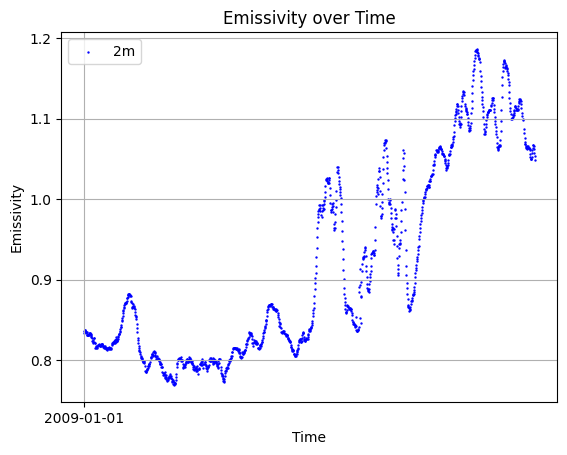

In [64]:
## Plot e_sky over time
plt.scatter(filtered_df.index[epsmask2], filtered_df['eps2'][epsmask2], label='2m', s=0.5, color='blue')
# plt.scatter(towermet_df.index[epsmask6], towermet_df['eps6'][epsmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towermet_df.index[epsmask10], towermet_df['eps10'][epsmask10], label='10m', s=0.5, color='red')

# Set ticks at regular intervals
# Find the start and end dates in your DataFrame
start_date = filtered_df.index.min()
end_date = filtered_df.index.max()

# # Generate ticks at regular intervals between start and end dates
ticks = pd.date_range(start=start_date, end=end_date, freq='5d')
tick_labels = [date.strftime('%Y-%m-%d') if i % 4 == 0 else None for i, date in enumerate(ticks)]

# Format the plot
plt.xticks(ticks, tick_labels)
plt.xlabel('Time')
plt.ylabel('Emissivity')
plt.title('Emissivity over Time')
plt.legend()
plt.grid()

# Save plot as .png
# plt.savefig('emissivity.png')

### Expected vs Measured DLR

Axis start at zero

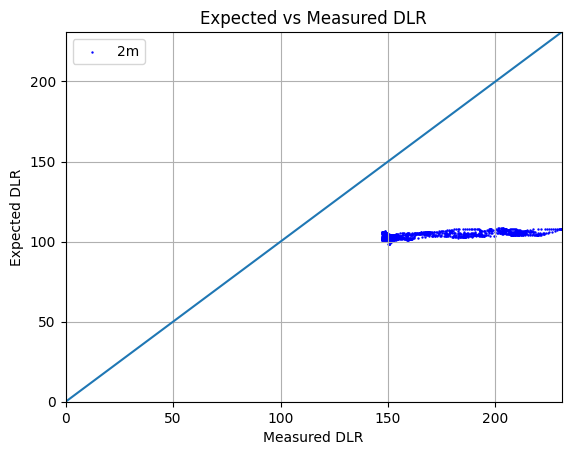

In [65]:
## Plot expected DLR vs measured DLR
plt.scatter(filtered_df['LWTotalDownwelling[W/m^2]'], filtered_df['DLR2'], label='2m', s=0.5, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(filtered_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(filtered_df['DLR2'][DLRmask2]))
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid()
plt.plot([0,max_value],[0,max_value])

# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

### Expected vs Measured DLR

Grid fitted to data (i.e. zoomed in)

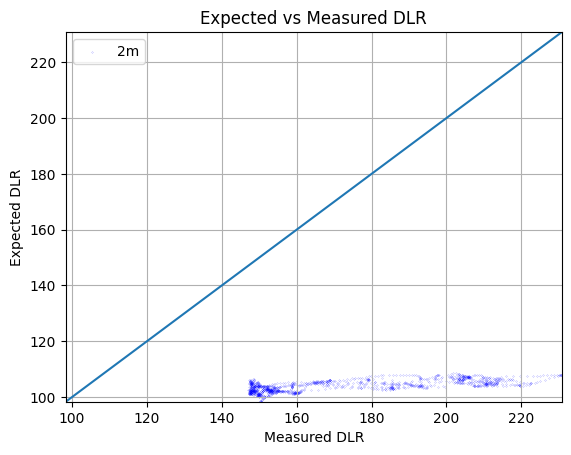

In [66]:
## Plot expected DLR vs measured DLR
plt.scatter(filtered_df['LWTotalDownwelling[W/m^2]'][DLRmask2], filtered_df['DLR2'][DLRmask2], label='2m', s=0.01, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(filtered_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(filtered_df['DLR2'][DLRmask2]))
min_value = min(np.nanmin(filtered_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmin(filtered_df['DLR2'][DLRmask2]))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.grid()
plt.plot([min_value,max_value],[min_value,max_value])


# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

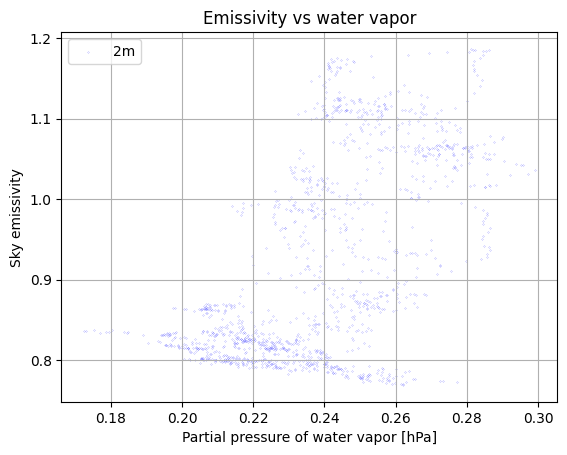

In [67]:
# Plot expected DLR vs measured DLR
plt.scatter(filtered_df['Pw2'], filtered_df['eps2'], label='2m', s=0.01, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
# max_value = max(np.nanmax(filtered_df['Pw2']), np.nanmax(filtered_df['eps2']))
# min_value = min(np.nanmin(filtered_df['Pw2']), np.nanmin(filtered_df['eps2']))
# plt.xlim(min_value, max_value)
# plt.ylim(min_value, max_value)
plt.grid()


# Format the plot
plt.xlabel('Partial pressure of water vapor [hPa]')
plt.ylabel('Sky emissivity')
plt.title('Emissivity vs water vapor')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

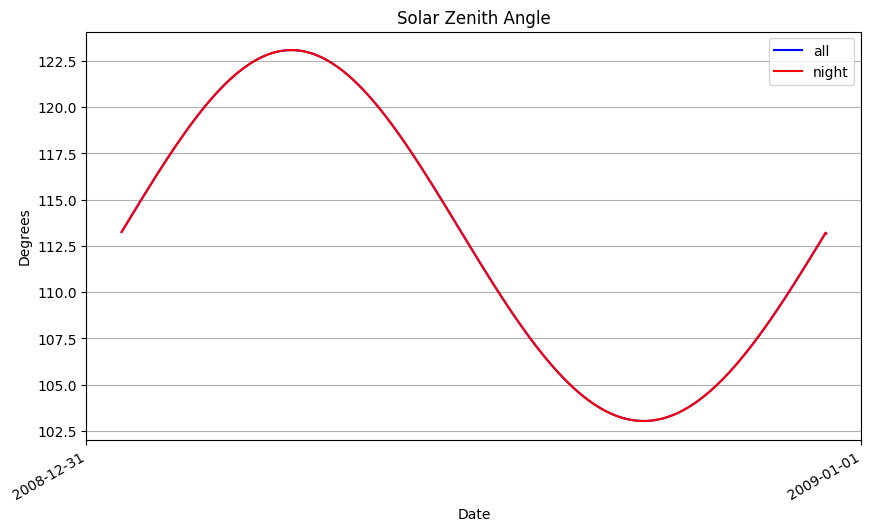

In [68]:
if 'isnight' in filter_keys:
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['LocalTime'], data_df['theta_z'], label='all', color='blue')
    plt.plot(filtered_df['LocalTime'], filtered_df['theta_z'], label='night', color='red')

    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show a tick every 5 days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date

    plt.xlabel('Date')
    plt.ylabel('Degrees')
    plt.title('Solar Zenith Angle')

    plt.grid(True)

    plt.gcf().autofmt_xdate()

    plt.legend()

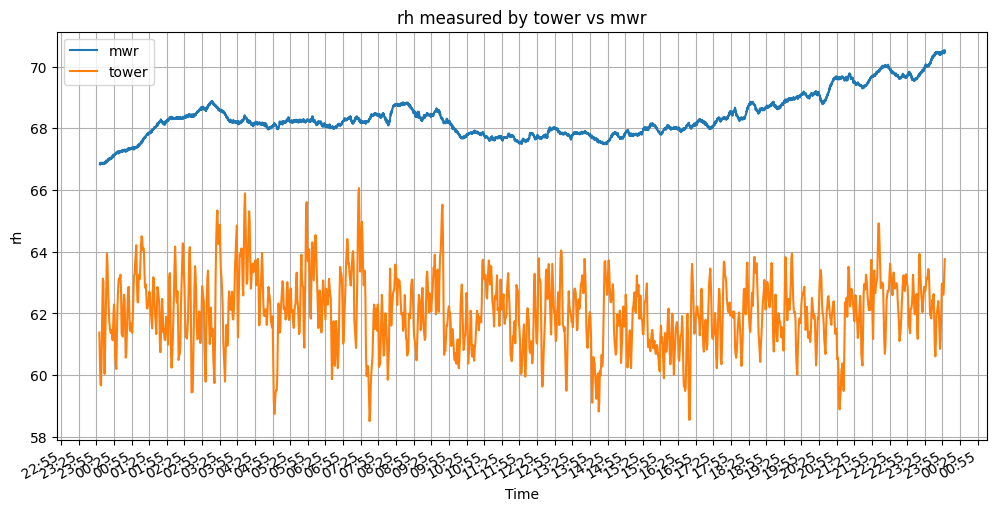

In [69]:
# Plot the first DataFrame
plt.figure(figsize=(12, 6))  # Set the figure size for better readability
merged_df['rh'].plot(label='mwr', legend=True)

# Plot the second DataFrame on the same axes
filtered_df['2MRH[%]'].plot(label='tower', legend=True)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('rh')
plt.title('rh measured by tower vs mwr')

# Optionally, you can format the x-axis to show the time more clearly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MinuteLocator(interval=30))  # Adjust the interval as needed

# Show grid for better readability
plt.grid(True)

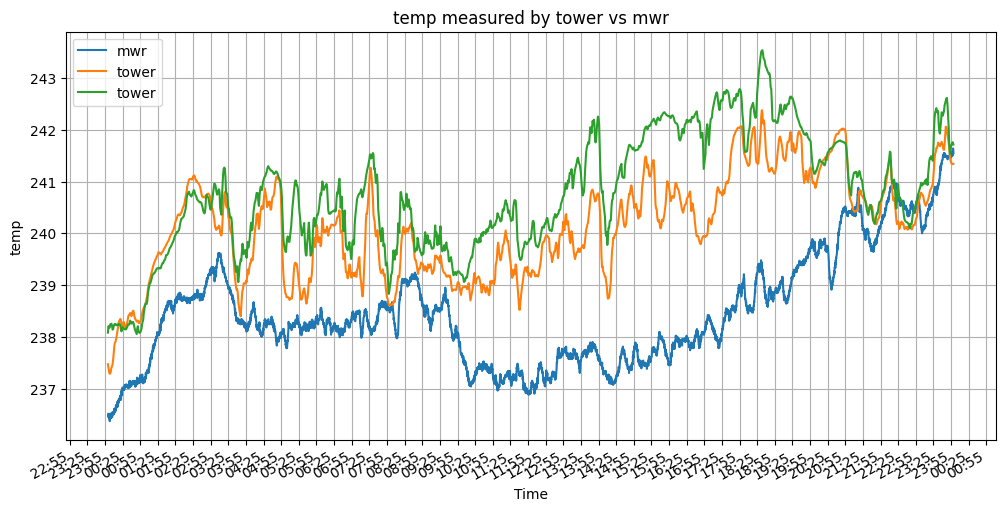

In [70]:
# Plot the first DataFrame
plt.figure(figsize=(12, 6))  # Set the figure size for better readability
merged_df['temperature'].plot(label='mwr', legend=True)

# Plot the second DataFrame on the same axes
filtered_df['T2_K'].plot(label='tower', legend=True)
filtered_df['T10_K'].plot(label='tower', legend=True)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('temp')
plt.title('temp measured by tower vs mwr')

# Optionally, you can format the x-axis to show the time more clearly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MinuteLocator(interval=30))  # Adjust the interval as needed

# Show grid for better readability
plt.grid(True)

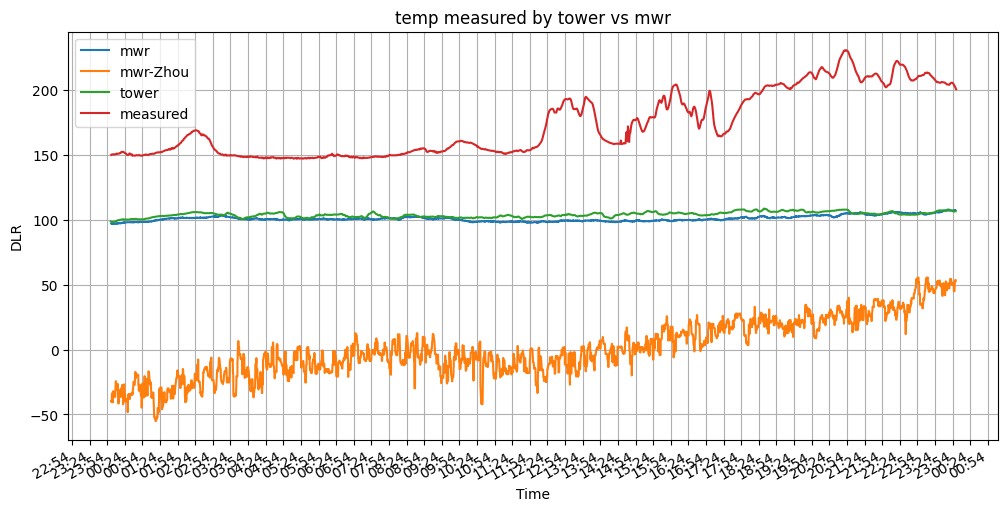

In [73]:
# Plot the first DataFrame
plt.figure(figsize=(12, 6))  # Set the figure size for better readability
merged_df['DLR2'].plot(label='mwr', legend=True)
merged_df['DLR'].plot(label='mwr-Zhou', legend=True)

# Plot the second DataFrame on the same axes
filtered_df['DLR2'].plot(label='tower', legend=True)
filtered_df['LWTotalDownwelling[W/m^2]'].plot(label='measured', legend=True)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('DLR')
plt.title('temp measured by tower vs mwr')

# Optionally, you can format the x-axis to show the time more clearly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MinuteLocator(interval=30))  # Adjust the interval as needed

# Show grid for better readability
plt.grid(True)